# Approach III: text Embedding - USE

In [ ]:
import pandas as pd
import re
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import TweetTokenizer
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import spacy
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import gensim.downloader as api
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
import xgboost

In [ ]:
# NLTK Downloads
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
file_path = 'HateXplain-Dataset.xlsx'
df = pd.read_excel(file_path)

print(df.columns)
df.head()

Index(['Unnamed: 0', 'origin_id', 'target', 'text', 'label'], dtype='object')


,Unnamed: 0,origin_id,target,text,label
0,0,1179055004553900032,NaN,i dont think im getting my baby them white 9 h...,nhs
1,1,1179063826874032128,NaN,we cannot continue calling ourselves feminists...,nhs
2,2,1178793830532956161,ethnicity,nawt yall niggers ignoring me,nhs
3,3,1179088797964763136,ethnicity,<user> i am bit confused coz chinese ppl can n...,hs
4,4,1179085312976445440,gender,this bitch in whataburger eating a burger with...,hs


In [ ]:
print(f"Dataset size (total number of elements): {df.size}")
print(f"Dataset shape (rows, columns): {df.shape}")

Dataset size (total number of elements): 79525
Dataset shape (rows, columns): (15905, 5)


In [ ]:
# Filter for rows where target is 'ethnicity'
ethnicity_df = df[df['target'] == 'ethnicity']

# Display the shape and first few rows of the filtered dataset
print(f"Ethnicity dataset shape: {ethnicity_df.shape}")
ethnicity_df.head()


Ethnicity dataset shape: (5801, 5)


,Unnamed: 0,origin_id,target,text,label
2,2,1178793830532956161,ethnicity,nawt yall niggers ignoring me,nhs
3,3,1179088797964763136,ethnicity,<user> i am bit confused coz chinese ppl can n...,hs
5,5,13851720,ethnicity,laura loomer raped me while screaming at me in...,hs
6,6,24198545,ethnicity,and this is why i end up with nigger trainee d...,hs
7,7,14567516,ethnicity,nogs jews and dykes how enriching,hs


In [ ]:
# Filter for rows where target is NaN
nan_target_df = df[df['target'].isnull()]

# Display the shape and first few rows of the filtered dataset
print(f"NaN target dataset shape: {nan_target_df.shape}")
nan_target_df.head()

NaN target dataset shape: (4850, 5)


,Unnamed: 0,origin_id,target,text,label
0,0,1179055004553900032,NaN,i dont think im getting my baby them white 9 h...,nhs
1,1,1179063826874032128,NaN,we cannot continue calling ourselves feminists...,nhs
11,11,1159278048069464065,NaN,<percent> cotton thigh highs to avoid contact ...,nhs
12,12,1170440965888335874,NaN,oomf a <number> yearl old closet gay and obses...,nhs
14,14,1122734457230774272,NaN,fellas be careful she texting other niggas,nhs


In [ ]:
# Filter for rows where target is NaN
nan_target_df = df[df['target'].isnull()]

# Display the shape and first few rows of the filtered dataset
print(f"NaN target dataset shape: {nan_target_df.shape}")
nan_target_df.head()

NaN target dataset shape: (4850, 5)


,Unnamed: 0,origin_id,target,text,label
0,0,1179055004553900032,NaN,i dont think im getting my baby them white 9 h...,nhs
1,1,1179063826874032128,NaN,we cannot continue calling ourselves feminists...,nhs
11,11,1159278048069464065,NaN,<percent> cotton thigh highs to avoid contact ...,nhs
12,12,1170440965888335874,NaN,oomf a <number> yearl old closet gay and obses...,nhs
14,14,1122734457230774272,NaN,fellas be careful she texting other niggas,nhs


In [ ]:
# Combine the two datasets (ethnicity and NaN target)
final_data = pd.concat([ethnicity_df, nan_target_df])

# Reset the index for the new DataFrame
final_data = final_data.reset_index(drop=True)

# Verify the 'target' column remains intact
print("Unique targets in the final dataset:")
print(final_data['target'].unique())

# Verify the 'label' column remains intact
print("Unique labels in the final dataset:")
print(final_data['label'].unique())

# Display the shape of the final dataset
print(f"Final dataset shape: {final_data.shape}")
final_data.head()

Unique targets in the final dataset:
['ethnicity' nan]
Unique labels in the final dataset:
['nhs' 'hs']
Final dataset shape: (10651, 5)


,Unnamed: 0,origin_id,target,text,label
0,2,1178793830532956161,ethnicity,nawt yall niggers ignoring me,nhs
1,3,1179088797964763136,ethnicity,<user> i am bit confused coz chinese ppl can n...,hs
2,5,13851720,ethnicity,laura loomer raped me while screaming at me in...,hs
3,6,24198545,ethnicity,and this is why i end up with nigger trainee d...,hs
4,7,14567516,ethnicity,nogs jews and dykes how enriching,hs


**Data Preprocessing**




In [ ]:
#drop unwanted columns
final_data = final_data.drop(['Unnamed: 0', 'origin_id'], axis=1)
final_data.head()

,target,text,label
0,ethnicity,nawt yall niggers ignoring me,nhs
1,ethnicity,<user> i am bit confused coz chinese ppl can n...,hs
2,ethnicity,laura loomer raped me while screaming at me in...,hs
3,ethnicity,and this is why i end up with nigger trainee d...,hs
4,ethnicity,nogs jews and dykes how enriching,hs


In [ ]:
# Check for missing values in the dataset
print("Missing values per column:")
print(final_data.isnull().sum())


Missing values per column:
target    4850
text         0
label        0
dtype: int64


Since there's no missing values, we r not handling the missing values

In [ ]:
#Remove unnecessary characters, such as mentions (@user), URLs, and special characters,

def clean_text(text):
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphanumeric characters
    text = text.lower()  # Convert to lowercase
    text = text.strip()  # Remove leading/trailing spaces
    return text

# Apply cleaning to the 'text' column
final_data['text'] = final_data['text'].apply(clean_text)

# Display a few cleaned rows
final_data.head()

,target,text,label
0,ethnicity,nawt yall niggers ignoring me,nhs
1,ethnicity,user i am bit confused coz chinese ppl can not...,hs
2,ethnicity,laura loomer raped me while screaming at me in...,hs
3,ethnicity,and this is why i end up with nigger trainee d...,hs
4,ethnicity,nogs jews and dykes how enriching,hs


In [ ]:
# integer label encoding

# Map 'hs' (hate speech, in this context xenophobic) to 1 and 'nhs' (non-hate speech, here non-xenophobic) to 0
final_data['label'] = final_data['label'].map({'hs': 1, 'nhs': 0})

# Verify the transformation
print(final_data['label'].value_counts())

label
0    5387
1    5264
Name: count, dtype: int64


In [ ]:
#Stopwords removal

# Define stop words set
stop_words = set(stopwords.words('english'))

# Add custom stop words
custom_stop_words = {"make", "anything", "user", "say", "right", "someone","number","go","something","know","want","everyone","even","your"}
stop_words.update(custom_stop_words)

# Remove stop words from the 'text' column
final_data['text'] = final_data['text'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in stop_words])
)

# Display a few rows to verify
final_data.head()


,target,text,label
0,ethnicity,nawt yall niggers ignoring,0
1,ethnicity,bit confused coz chinese ppl access twitter th...,1
2,ethnicity,laura loomer raped screaming disgusting kike l...,1
3,ethnicity,end nigger trainee doctors speak properly lack...,1
4,ethnicity,nogs jews dykes enriching,1


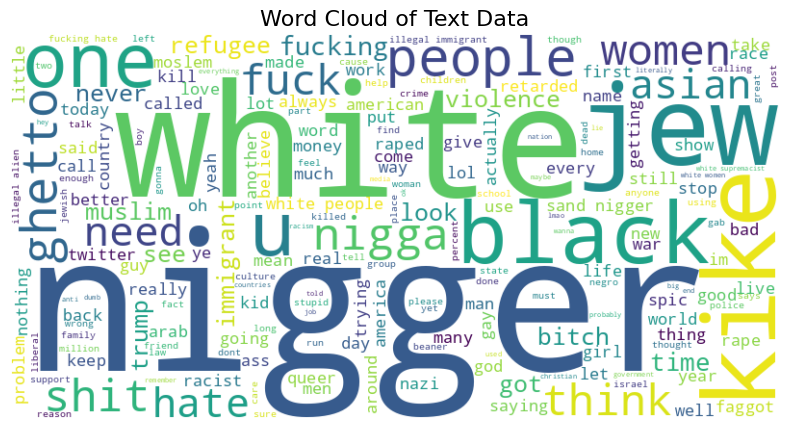

In [ ]:
#WordCloud

# Combine all text into one string
all_text = ' '.join(final_data['text'])

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Text Data", fontsize=16)
plt.show()


*italicized text*# **Approach III - Text Embedding via Bert and USE**

Split dataset

In [ ]:
final_data.head()

,target,text,label
0,ethnicity,nawt yall niggers ignoring,0
1,ethnicity,bit confused coz chinese ppl access twitter th...,1
2,ethnicity,laura loomer raped screaming disgusting kike l...,1
3,ethnicity,end nigger trainee doctors speak properly lack...,1
4,ethnicity,nogs jews dykes enriching,1


In [ ]:
import tensorflow_hub as hub
# Assuming the dataset has a 'text' column with the tweets/comments
texts = final_data['text']  # Extract text data
labels = final_data['label']  # Extract labels (assuming it's already encoded)

# Step 3: Load Universal Sentence Encoder
use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# Step 4: Generate USE Embeddings
def generate_use_embeddings(texts):
    """
    Generate embeddings for a list of text using the Universal Sentence Encoder.
    """
    embeddings = use_model(texts.tolist())  # Convert to list and pass to USE
    return embeddings.numpy()  # Convert TensorFlow tensor to NumPy array

# Generate embeddings for the entire dataset
text_embeddings = generate_use_embeddings(texts)


Split the Dataset

In [ ]:
# Split the embeddings and labels into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(text_embeddings, labels, test_size=0.2, random_state=42)

# Print the shapes to verify
print("Training Embeddings Shape:", X_train.shape)
print("Testing Embeddings Shape:", X_test.shape)

Training Embeddings Shape: (8520, 512)
Testing Embeddings Shape: (2131, 512)


Bert

# Set Up the Training Models

In [ ]:
from sklearn.svm import SVC

# Train an SVM classifier
svm_clf = SVC(kernel='linear', random_state=42)
svm_clf.fit(X_train, y_train)

# Predict on the test set
y_pred = svm_clf.predict(X_test)

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8160488033786955
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.85      0.82      1051
           1       0.84      0.79      0.81      1080

    accuracy                           0.82      2131
   macro avg       0.82      0.82      0.82      2131
weighted avg       0.82      0.82      0.82      2131



In [ ]:
from xgboost import XGBClassifier


# Step 5: Train an XGBoost Classifier
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')  # Avoid warning for logloss
xgb_clf.fit(X_train, y_train)

# Step 6: Make Predictions
y_pred = xgb_clf.predict(X_test)

# Step 7: Evaluate Performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:40:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.8226184889723135
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.85      0.83      1051
           1       0.85      0.79      0.82      1080

    accuracy                           0.82      2131
   macro avg       0.82      0.82      0.82      2131
weighted avg       0.82      0.82      0.82      2131



In [ ]:
from sklearn.linear_model import LogisticRegression

# Step 5: Train Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)  # Increase max_iter if needed
log_reg.fit(X_train, y_train)

# Step 6: Make Predictions
y_pred = log_reg.predict(X_test)

# Step 7: Evaluate Performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8071328015016425
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.83      0.81      1051
           1       0.83      0.78      0.80      1080

    accuracy                           0.81      2131
   macro avg       0.81      0.81      0.81      2131
weighted avg       0.81      0.81      0.81      2131

